In [205]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.utils import resample
from string import punctuation
import re
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [206]:
reviews_raw = pd.read_json('reviews_Sports_And_Outdoors_5.JSON', lines=True)
pd.DataFrame.from_dict(reviews_raw, orient='columns')
reviews_raw.head(10)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1881509818,"[0, 0]",5,This came in on time and I am veru happy with ...,"01 26, 2014",AIXZKN4ACSKI,David Briner,Woks very good,1390694400
1,1881509818,"[1, 1]",5,I had a factory Glock tool that I was using fo...,"02 2, 2012",A1L5P841VIO02V,Jason A. Kramer,Works as well as the factory tool,1328140800
2,1881509818,"[2, 2]",4,If you don't have a 3/32 punch or would like t...,"02 28, 2012",AB2W04NI4OEAD,J. Fernald,"It's a punch, that's all.",1330387200
3,1881509818,"[0, 0]",4,This works no better than any 3/32 punch you w...,"02 5, 2012",A148SVSWKTJKU6,"Jusitn A. Watts ""Maverick9614""",It's a punch with a Glock logo.,1328400000
4,1881509818,"[0, 0]",4,I purchased this thinking maybe I need a speci...,"04 23, 2013",AAAWJ6LW9WMOO,Material Man,"Ok,tool does what a regular punch does.",1366675200
5,1881509818,"[0, 0]",5,"Needed this tool to really break down my G22, ...","11 2, 2012",A2XX2A4OJCDNLZ,RatherLiveInKeyWest,Glock punch tool - needed for your Glock and o...,1351814400
6,1881509818,"[0, 0]",5,If u don't have it .. Get it. All you need to ...,"06 10, 2014",A283UOBQRUNM4Q,Thomas Dragon,Great tool,1402358400
7,2094869245,"[0, 0]",4,This light will no doubt capture the attention...,"08 31, 2013",AWG3H90WVZ0Z1,Alec Nelson,Bright!,1377907200
8,2094869245,"[0, 1]",5,"Light and laser torch work well, very bright. ...","05 27, 2013",A3V52OTJHKIJZX,"A. Saenz Jr. ""Bettering self""",Be seen,1369612800
9,2094869245,"[0, 0]",5,Does everything it says it will do. I would li...,"11 2, 2013",A3SZBE5F3UQ9EC,"ChasRat ""ChasRat""",Bicycle rear tail light,1383350400


In [207]:
null_count = reviews_raw.isnull().sum()
null_count[null_count>0]

reviewerName    1402
dtype: int64

In [208]:
df2 = reviews_raw.drop(['reviewerID', 'reviewerName', 'asin', 'helpful', 'reviewTime', 'summary', 
                       'unixReviewTime'], 1)
threshold = 4
df2['Sentiment'] = np.where(df2['overall'] >= threshold, 1,0)
df2 = df2.drop(['overall'], 1)

df2.head(10)

,reviewText,Sentiment
0,This came in on time and I am veru happy with ...,1
1,I had a factory Glock tool that I was using fo...,1
2,If you don't have a 3/32 punch or would like t...,1
3,This works no better than any 3/32 punch you w...,1
4,I purchased this thinking maybe I need a speci...,1
5,"Needed this tool to really break down my G22, ...",1
6,If u don't have it .. Get it. All you need to ...,1
7,This light will no doubt capture the attention...,1
8,"Light and laser torch work well, very bright. ...",1
9,Does everything it says it will do. I would li...,1


In [209]:
df2['Sentiment'].value_counts()

1    253017
0     43320
Name: Sentiment, dtype: int64

In [210]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

for review in df2['reviewText']:
    review = text_cleaner(review)

df2.head(10)

,reviewText,Sentiment
0,This came in on time and I am veru happy with ...,1
1,I had a factory Glock tool that I was using fo...,1
2,If you don't have a 3/32 punch or would like t...,1
3,This works no better than any 3/32 punch you w...,1
4,I purchased this thinking maybe I need a speci...,1
5,"Needed this tool to really break down my G22, ...",1
6,If u don't have it .. Get it. All you need to ...,1
7,This light will no doubt capture the attention...,1
8,"Light and laser torch work well, very bright. ...",1
9,Does everything it says it will do. I would li...,1


In [211]:
positive = df2.loc[df2['Sentiment'] == 1]
negative = df2.loc[df2['Sentiment'] == 0]
df3 = resample(positive, n_samples=43320)
negative = resample(negative, n_samples=43320)
df3 = df3.append(negative)
df3['Sentiment'].value_counts()

1    43320
0    43320
Name: Sentiment, dtype: int64

In [212]:
X = df3['reviewText']
y = df3['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
vect2 = TfidfVectorizer(min_df=20, analyzer = 'word', stop_words = 'english', ngram_range = (1,2) ).fit(X_train)

X_train_vectorized = vect2.transform(X_train)
X_test_vectorized = vect2.transform(X_test)


In [213]:
def testing_func(model):
    
    model.fit(X_train_vectorized, y_train)
    model.fit(X_test_vectorized, y_test)

    # Inspect the results.
    print('\nR-squared for the Training Set:')
    print(model.score(X_train_vectorized, y_train))
    print('\nR-squared for the Test Set:')
    print(model.score(X_test_vectorized, y_test))
    print('Cross Validation Scores with 10 folds: {}'.format(cross_val_score(model, X_train_vectorized, y_train, cv=10)))

In [214]:
start = datetime.now()
#Let's put our variables through Naive Bayes.
bnb = BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

testing_func(bnb)
print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set:
0.731825385888

R-squared for the Test Set:
0.7746922216
Cross Validation Scores with 10 folds: [ 0.75745047  0.75607235  0.75762274  0.74315245  0.75538329  0.75521102
  0.75297158  0.7464255   0.74160207  0.74306393]
It took the following time to complete this task: 0:00:01.682649


In [215]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=1, penalty='l1')
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set:
0.793498484013

R-squared for the Test Set:
0.830477056519
Cross Validation Scores with 10 folds: [ 0.81171404  0.80861326  0.81050818  0.81343669  0.80861326  0.81016365
  0.8124031   0.79259259  0.80258398  0.80148199]
It took the following time to complete this task: 0:00:10.329612


In [216]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=1, penalty='l2')
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set:
0.805678059537

R-squared for the Test Set:
0.867655288193
Cross Validation Scores with 10 folds: [ 0.81739879  0.81670973  0.81963824  0.8203273   0.81774332  0.8118863
  0.81912145  0.80068906  0.81843239  0.81233845]
It took the following time to complete this task: 0:00:09.261817


In [217]:
"""start = datetime.now()
#Now let's model with SVM
svc = SVC(C=2, gamma=0.01)
testing_func(svc)

print('It took the following time to complete this task:', datetime.now() - start)"""

"start = datetime.now()\n#Now let's model with SVM\nsvc = SVC(C=2, gamma=0.01)\ntesting_func(svc)\n\nprint('It took the following time to complete this task:', datetime.now() - start)"

In [218]:
start = datetime.now()
clf = DecisionTreeClassifier(max_depth=8, random_state=0)
testing_func(clf)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set:
0.650254961411

R-squared for the Test Set:
0.663577224398
Cross Validation Scores with 10 folds: [ 0.64702842  0.65633075  0.65236865  0.65891473  0.65236865  0.66063738
  0.64771748  0.64857881  0.64409991  0.64156471]
It took the following time to complete this task: 0:00:43.905235


In [219]:
start = datetime.now()
#Now let's model with Random Forest
rfc = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                      max_leaf_nodes=2, min_impurity_decrease=0.0, min_impurity_split=None, 
                                      bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
                                      warm_start=False, class_weight=None)

testing_func(rfc)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set:
0.549390159868

R-squared for the Test Set:
0.5501538892
Cross Validation Scores with 10 folds: [ 0.5881137   0.56106804  0.54745909  0.55762274  0.54952627  0.5667528
  0.55245478  0.54866494  0.53436693  0.53368947]
It took the following time to complete this task: 0:00:03.777888


In [220]:
start = datetime.now()
#Now let's model with Gradient Boosting
clf = GradientBoostingClassifier(loss='deviance', learning_rate=1.0, n_estimators=10, subsample=1.0, 
                                          criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_depth=2, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                          verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')

testing_func(clf)
print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set:
0.669842199559

R-squared for the Test Set:
0.678056799105
Cross Validation Scores with 10 folds: [ 0.66666667  0.67596899  0.66477175  0.6794143   0.67011197  0.68372093
  0.6670112   0.67011197  0.66735573  0.66482854]
It took the following time to complete this task: 0:01:24.210387


Althought Bernoulli Bayes works fairly well, Ridge and Lasso Regression performed the best of all the models with around 0.80 Accuracy with similar scores on the Cross Validation/Test meaning that it likely isn't overfitting the data.

In [221]:
reviews_raw2 = pd.read_json('reviews_Automotive_5.json', lines=True)
pd.DataFrame.from_dict(reviews_raw2, orient='columns')
reviews_raw2.head(10)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,I needed a set of jumper cables for my new car...,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but ...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5,Can't comment much on these since they have no...,"07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5,I absolutley love Amazon!!! For the price of ...,"12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5,I purchased the 12' feet long cable set and th...,"07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000
5,B00002243X,"[1, 1]",5,"These Jumper cables are heavy Duty, Yet easy t...","11 14, 2009",A1ORODEBRN64C,"James F. Magowan ""Jimmy Mac""",Compact and Strong !,1258156800
6,B00002243X,"[1, 1]",5,bought these for my k2500 suburban plenty of l...,"01 10, 2012",A2R49ZN3G6FTCQ,John M. Harrell,nice cables,1326153600
7,B00002243X,"[0, 0]",5,these are good enough to get most motorized ve...,"06 13, 2013",A1Q65KYDKXIX8E,Leeland H.,for cars and pickups,1371081600
8,B00002243X,"[0, 0]",4,The Coleman Cable 08665 12-Feet Heavy-Duty Tru...,"07 18, 2013",A3BI8BKIHESDNQ,L. J. Cunningham,Coleman Cable 08665 12-Feet Heavy-Duty Truck a...,1374105600
9,B00002243X,"[0, 0]",5,"I have an old car, Its bound to need these som...","01 22, 2014",A1R089P5AS26UE,Mike,Beefy,1390348800


In [222]:
seconddf2 = reviews_raw.drop(['reviewerID', 'reviewerName', 'asin', 'helpful', 'reviewTime', 'summary', 
                       'unixReviewTime'], 1)
threshold = 4
seconddf2['Sentiment'] = np.where(seconddf2['overall'] >= threshold, 1,0)
seconddf2 = seconddf2.drop(['overall'], 1)

seconddf2.head(10)

,reviewText,Sentiment
0,This came in on time and I am veru happy with ...,1
1,I had a factory Glock tool that I was using fo...,1
2,If you don't have a 3/32 punch or would like t...,1
3,This works no better than any 3/32 punch you w...,1
4,I purchased this thinking maybe I need a speci...,1
5,"Needed this tool to really break down my G22, ...",1
6,If u don't have it .. Get it. All you need to ...,1
7,This light will no doubt capture the attention...,1
8,"Light and laser torch work well, very bright. ...",1
9,Does everything it says it will do. I would li...,1


In [223]:
seconddf2['Sentiment'].value_counts()

1    253017
0     43320
Name: Sentiment, dtype: int64

In [224]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

for review in seconddf2['reviewText']:
    review = text_cleaner(review)

seconddf2.head(10)

,reviewText,Sentiment
0,This came in on time and I am veru happy with ...,1
1,I had a factory Glock tool that I was using fo...,1
2,If you don't have a 3/32 punch or would like t...,1
3,This works no better than any 3/32 punch you w...,1
4,I purchased this thinking maybe I need a speci...,1
5,"Needed this tool to really break down my G22, ...",1
6,If u don't have it .. Get it. All you need to ...,1
7,This light will no doubt capture the attention...,1
8,"Light and laser torch work well, very bright. ...",1
9,Does everything it says it will do. I would li...,1


In [225]:

positive = seconddf2.loc[df2['Sentiment'] == 1]
negative = seconddf2.loc[df2['Sentiment'] == 0]
seconddf3 = resample(positive, n_samples=3000)
negative = resample(negative, n_samples=3000)
seconddf3 = seconddf3.append(negative)
seconddf3['Sentiment'].value_counts()

1    3000
0    3000
Name: Sentiment, dtype: int64

In [226]:
y = seconddf3['Sentiment']
lr = LogisticRegression(C=1, penalty='l1')
lr.fit(X_train_vectorized, y_train)
T = seconddf3['reviewText']

X_train_vectorized2 = vect2.transform(T)

<function matplotlib.pyplot.show>

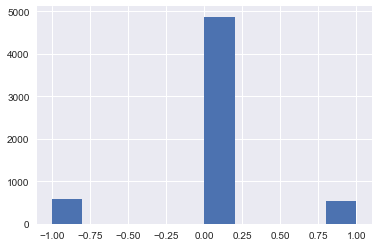

In [227]:
# Extract predicted values.
predicted = lr.predict(X_train_vectorized2)
actual = seconddf3['Sentiment']

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.show